# PU.1 and GATA1 perturbation

Notebooks for PU.1 (SPI1) and GATA1 gene perturbation

## Library imports

In [1]:
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.lines import Line2D

import cellrank as cr
import scanpy as sc
import scvelo as scv
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output
from rgv_tools.perturbation import in_silico_block_simulation, inferred_GRN

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [4]:
DATASET = "hematopoiesis"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [6]:
terminal_states = ["Meg", "Mon", "Bas", "Ery", "Neu"]

## Data loading

In [7]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")
TF = adata.var_names[adata.var["TF"]]

## PU.1 and GATA1 perturbation

### Model loading

In [8]:
vae = REGVELOVI.load(DATA_DIR / DATASET / "processed" / "rgv_model", adata)
set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/rgv_model/model.pt already
         downloaded                                                                                                


In [9]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
estimator = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=7, cluster_key="cell_type")
estimator.set_terminal_states(terminal_states)
estimator.compute_fate_probabilities()

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

2024-11-25 23:17:21,194 - INFO - Using pre-computed Schur decomposition


Defaulting to `'gmres'` solver.


  0%|          | 0/5 [00:00<?, ?/s]

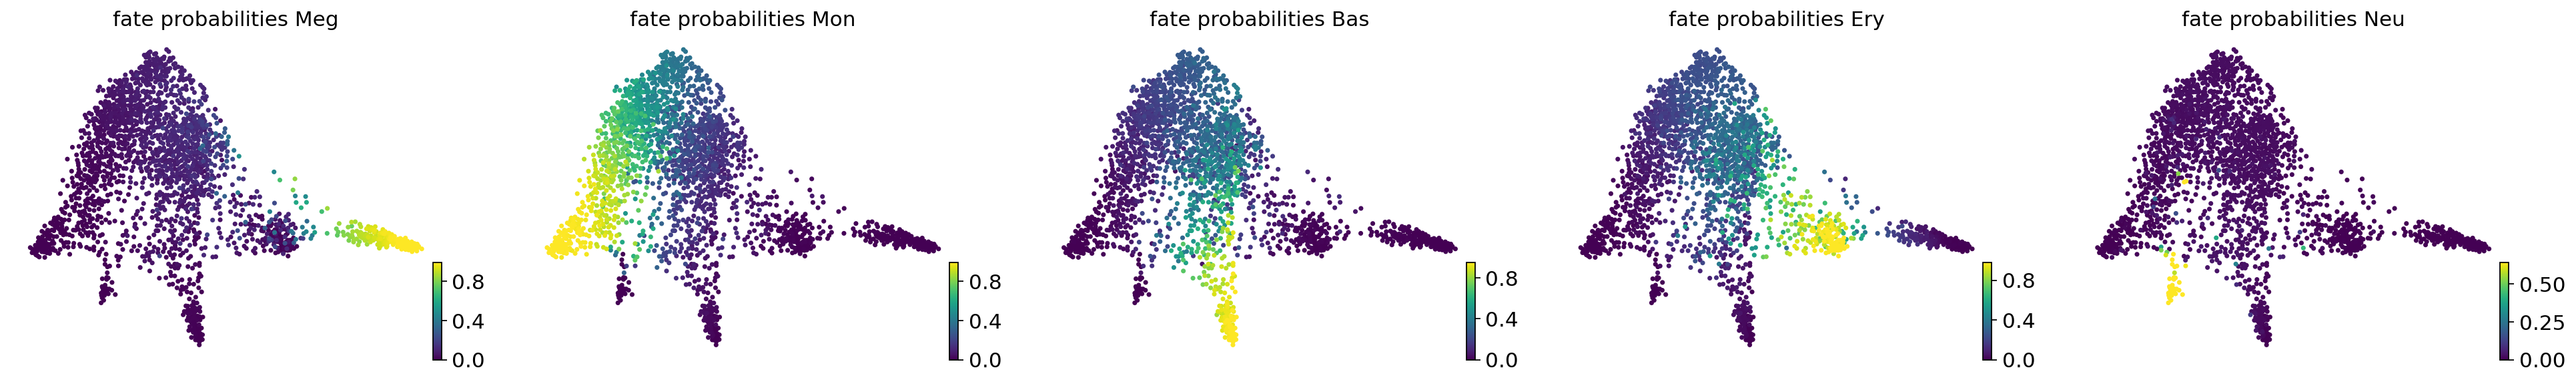

In [10]:
estimator.plot_fate_probabilities(same_plot=False, basis="draw_graph_fa")

### Knockout GATA1 simulation

In [11]:
adata_perturb, vae_perturb = in_silico_block_simulation(
    DATA_DIR / DATASET / "processed" / "rgv_model", adata, "GATA1", effects=0
)

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/rgv_model/model.pt already
         downloaded                                                                                                


In [12]:
vk = cr.kernels.VelocityKernel(adata_perturb)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_perturb).compute_transition_matrix()
estimator = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=7, cluster_key="cell_type")
estimator.set_terminal_states(terminal_states)
estimator.compute_fate_probabilities()

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

2024-11-25 23:17:51,494 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/5 [00:00<?, ?/s]

In [13]:
cond1_df = pd.DataFrame(
    adata_perturb.obsm["lineages_fwd"], columns=adata_perturb.obsm["lineages_fwd"].names.tolist()
)  # perturbed cell fate probabilities
cond2_df = pd.DataFrame(
    adata.obsm["lineages_fwd"], columns=adata.obsm["lineages_fwd"].names.tolist()
)  # original cell fate probabilities

In [18]:
## plot
cell_fate = []
for i in range(cond1_df.shape[0]):
    if cond2_df.iloc[i, 1] > 0.7 and np.abs(cond1_df.iloc[i, 1] - cond2_df.iloc[i, 1]) > 0:
        cell_fate.append(cond1_df.iloc[i, 3] - cond2_df.iloc[i, 3])
    elif cond2_df.iloc[i, 3] > 0.7 and np.abs(cond1_df.iloc[i, 3] - cond2_df.iloc[i, 3]) > 0:
        cell_fate.append(cond1_df.iloc[i, 3] - cond2_df.iloc[i, 3])
    else:
        cell_fate.append(np.nan)

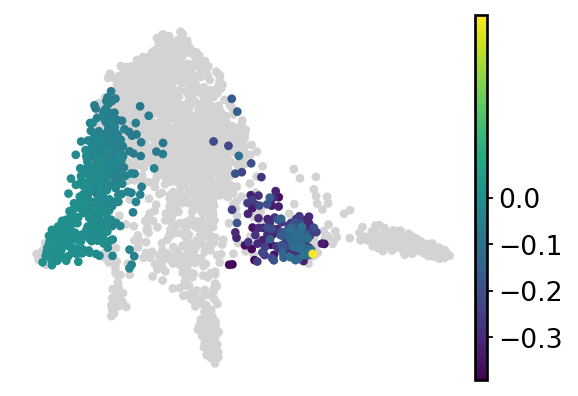

In [19]:
adata.obs["GATA1_perturb_effects"] = cell_fate
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    sc.pl.embedding(
        adata, basis="draw_graph_fa", color="GATA1_perturb_effects", frameon=False, title="", ax=ax, vcenter=0
    )

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "GATA1_perturbation.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Knockout SPI1 simulation

In [22]:
adata_perturb, vae_perturb = in_silico_block_simulation(
    DATA_DIR / DATASET / "processed" / "rgv_model", adata, "SPI1", effects=0
)

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/rgv_model/model.pt already
         downloaded                                                                                                


In [23]:
vk = cr.kernels.VelocityKernel(adata_perturb)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_perturb).compute_transition_matrix()
estimator = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=7, cluster_key="cell_type")
estimator.set_terminal_states(terminal_states)
estimator.compute_fate_probabilities()

  0%|          | 0/1947 [00:00<?, ?cell/s]

  0%|          | 0/1947 [00:00<?, ?cell/s]

2024-11-25 23:19:28,030 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/5 [00:00<?, ?/s]

In [24]:
cond1_df = pd.DataFrame(
    adata_perturb.obsm["lineages_fwd"], columns=adata_perturb.obsm["lineages_fwd"].names.tolist()
)  # perturbed cell fate probabilities
cond2_df = pd.DataFrame(
    adata.obsm["lineages_fwd"], columns=adata.obsm["lineages_fwd"].names.tolist()
)  # original cell fate probabilities

In [27]:
## plot
cell_fate = []
for i in range(cond1_df.shape[0]):
    if cond2_df.iloc[i, 1] > 0.7 and np.abs(cond1_df.iloc[i, 1] - cond2_df.iloc[i, 1]) > 0:
        cell_fate.append(cond1_df.iloc[i, 1] - cond2_df.iloc[i, 1])
    elif cond2_df.iloc[i, 3] > 0.7 and np.abs(cond1_df.iloc[i, 3] - cond2_df.iloc[i, 3]) > 0:
        cell_fate.append(cond1_df.iloc[i, 3] - cond2_df.iloc[i, 3])
    else:
        cell_fate.append(np.nan)

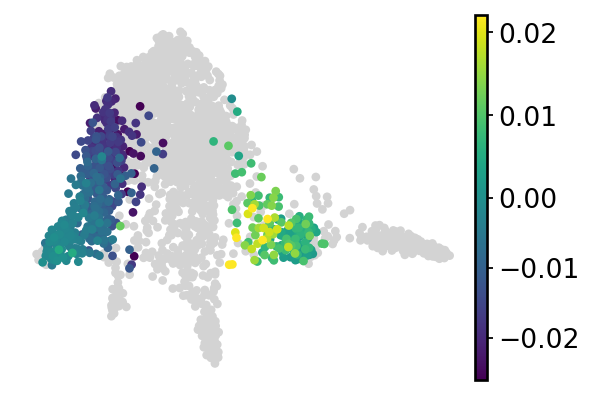

In [28]:
adata.obs["SPI1_perturb_effects"] = cell_fate
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    sc.pl.embedding(
        adata,
        basis="draw_graph_fa",
        color="SPI1_perturb_effects",
        frameon=False,
        vmin="p1",
        vmax="p99",
        title="",
        ax=ax,
        vcenter=0,
    )

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "SPI1_perturbation.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Gene regulation motif between PU.1 and GATA1

In [20]:
model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_0"
vae = REGVELOVI.load(model, adata)
reg1 = inferred_GRN(vae, adata, label="cell_type", group=["Ery", "Meg"])

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_1"
vae = REGVELOVI.load(model, adata)
reg2 = inferred_GRN(vae, adata, label="cell_type", group=["Ery", "Meg"])

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_2"
vae = REGVELOVI.load(model, adata)
reg3 = inferred_GRN(vae, adata, label="cell_type", group=["Ery", "Meg"])

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_3"
vae = REGVELOVI.load(model, adata)
reg4 = inferred_GRN(vae, adata, label="cell_type", group=["Ery", "Meg"])

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_4"
vae = REGVELOVI.load(model, adata)
reg5 = inferred_GRN(vae, adata, label="cell_type", group=["Ery", "Meg"])

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_0
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_1
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_2
         /model.pt already downloaded                                   

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on y

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_4
         /model.pt already downloaded                                                                              


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(


In [21]:
regMotif = np.stack((reg1, reg2, reg3, reg4, reg5), axis=0)
regMotif = np.mean(regMotif, axis=0)

In [22]:
targets = regMotif[:, [i == "GATA1" for i in adata.var.index]].reshape(-1)
targets = pd.DataFrame(targets, index=adata.var.index)
targets.loc[:, "weight"] = targets.iloc[:, 0]
targets.sort_values("weight", ascending=False).iloc[:20, :]

,0,weight
HBD,22.301508,22.301508
KEL,11.961169,11.961169
HBB,11.001174,11.001174
P2RX1,9.592329,9.592329
RUFY1,8.332366,8.332366
BLVRB,6.952588,6.952588
TAL1,6.601087,6.601087
SLC37A1,5.963588,5.963588
DAAM1,5.943871,5.943871
STXBP5,5.741522,5.741522


In [23]:
model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_0"
vae = REGVELOVI.load(model, adata)
reg1 = inferred_GRN(vae, adata, label="cell_type", group=["Neu", "Mon"])

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_1"
vae = REGVELOVI.load(model, adata)
reg2 = inferred_GRN(vae, adata, label="cell_type", group=["Neu", "Mon"])

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_2"
vae = REGVELOVI.load(model, adata)
reg3 = inferred_GRN(vae, adata, label="cell_type", group=["Neu", "Mon"])

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_3"
vae = REGVELOVI.load(model, adata)
reg4 = inferred_GRN(vae, adata, label="cell_type", group=["Neu", "Mon"])

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_4"
vae = REGVELOVI.load(model, adata)
reg5 = inferred_GRN(vae, adata, label="cell_type", group=["Neu", "Mon"])

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_0
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_1
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_2
         /model.pt already downloaded                                   

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on y

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_3
         /model.pt already downloaded                                                                              
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_4
         /model.pt already downloaded                                                                              


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(


In [24]:
regMotif = np.stack((reg1, reg2, reg3, reg4, reg5), axis=0)
regMotif = np.mean(regMotif, axis=0)

In [25]:
targets = regMotif[:, [i == "SPI1" for i in adata.var.index]].reshape(-1)
targets = pd.DataFrame(targets, index=adata.var.index)
targets.loc[:, "weight"] = targets.iloc[:, 0]
targets.sort_values("weight", ascending=False).iloc[:20, :]

,0,weight
SND1,13.434076,13.434076
STT3B,11.143422,11.143422
HLA-DPB1,9.534171,9.534171
ARHGAP30,8.252996,8.252996
P2RY8,5.347001,5.347001
TAF1,4.413145,4.413145
CCDC88B,3.921804,3.921804
CD63,3.603989,3.603989
NFIB,3.186572,3.186572
TCF4,2.952924,2.952924


## Visualize global GRN

In [26]:
model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_0"
vae = REGVELOVI.load(model, adata)
reg1 = inferred_GRN(vae, adata, label="cell_type", group="all")

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_1"
vae = REGVELOVI.load(model, adata)
reg2 = inferred_GRN(vae, adata, label="cell_type", group="all")

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_2"
vae = REGVELOVI.load(model, adata)
reg3 = inferred_GRN(vae, adata, label="cell_type", group="all")

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_3"
vae = REGVELOVI.load(model, adata)
reg4 = inferred_GRN(vae, adata, label="cell_type", group="all")

model = DATA_DIR / DATASET / "processed" / "perturb_repeat_runs" / "rgv_model_4"
vae = REGVELOVI.load(model, adata)
reg5 = inferred_GRN(vae, adata, label="cell_type", group="all")

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_0
         /model.pt already downloaded                                                                              
Computing global GRN...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_1
         /model.pt already downloaded                                                                              
Computing global GRN...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_2
         /model.pt alrea

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on y

Computing global GRN...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/data/hematopoiesis/processed/perturb_repeat_runs/rgv_model_4
         /model.pt already downloaded                                                                              
Computing global GRN...


/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/weixu.wang/miniconda3/envs/regvelo_test/li ...
  rank_zero_warn(


In [27]:
regMotif = np.stack((reg1, reg2, reg3, reg4, reg5), axis=0)
regMotif = np.mean(regMotif, axis=0)

## Plot toggle switch

In [28]:
motif = [
    ["SPI1", "GATA1", regMotif[[i == "GATA1" for i in adata.var.index], [i == "SPI1" for i in adata.var.index]][0]],
    ["GATA1", "SPI1", regMotif[[i == "SPI1" for i in adata.var.index], [i == "GATA1" for i in adata.var.index]][0]],
]
motif = pd.DataFrame(motif)

In [29]:
motif.columns = ["from", "to", "weight"]

In [30]:
motif["weight"] = np.sign(motif["weight"])

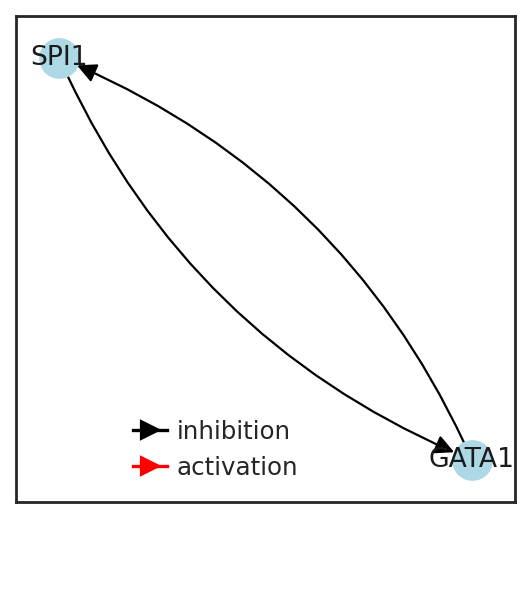

In [31]:
legend_elements = [
    Line2D([0], [0], marker=">", color="black", label="inhibition", markerfacecolor="black", markersize=8),
    Line2D([0], [0], marker=">", color="red", label="activation", markerfacecolor="red", markersize=8),
]

with mplscience.style_context():
    sns.set(style="white")
    fig, ax = plt.subplots(figsize=(4, 4))

    cont = motif
    contLines = []
    genes = set()
    G = nx.MultiDiGraph()
    pEdges = []
    nEdges = []
    for line in range(cont.shape[0]):
        tmp = cont.iloc[line, :]
        genes.add(tmp[0])
        genes.add(tmp[1])
        contLines.append(tmp.tolist())
    genes = list(genes)
    selfActGenes = set()
    selfInhGenes = set()
    G.add_nodes_from(genes)
    for edge in contLines:
        row = genes.index(edge[0])
        col = genes.index(edge[1])
        if edge[2] == 1:
            pEdges.append((edge[0], edge[1]))
            if row == col:
                selfActGenes.add(edge[0])
        elif edge[2] == -1:
            nEdges.append((edge[0], edge[1]))
            if row == col:
                selfInhGenes.add(edge[0])
        else:
            print("Unsupported regulatory relationship.")
    selfActGenes = list(selfActGenes)
    selfInhGenes = list(selfInhGenes)
    # show grn by network visualization
    G.add_edges_from(pEdges)
    G.add_edges_from(nEdges)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color="lightblue")  # initial colors for all nodes
    nx.draw_networkx_nodes(G, pos, nodelist=selfActGenes, node_color="red")  # red colors indicating activation
    nx.draw_networkx_nodes(G, pos, nodelist=selfInhGenes, node_color="black")  # black colors indicating inhibition
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=pEdges, edge_color="red", connectionstyle="arc3,rad=0.2", arrowsize=18)
    nx.draw_networkx_edges(
        G, pos, edgelist=nEdges, edge_color="black", arrows=True, connectionstyle="arc3,rad=0.2", arrowsize=18
    )
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.4, 0))

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "SPI1-GATA1-network.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()